# 05 Trying to build good decision algorithm for buying and selling

In [65]:
import plot_helper as ph
from pandas.tseries.offsets import DateOffset
import numpy as np
from datetime import datetime


In [8]:
import data_prep_helper
do_big = data_prep_helper.ModelData(chart_col=["Price", "High", "Low", "Price_norm"])


Using TensorFlow backend.


In [18]:
dates = do_big.get_forecast_dates()

In [172]:
budget = 100000

growth_list = []
for curr_day in dates[30:]:
    day_dict = {}
    ari_forecast = do_big.ari_forecast(curr_day, shift=-31)
    ari_df = ari_forecast.predicted_mean
    ari_df.index = ari_df.index + DateOffset(31)
    
    gru_df = do_big.gru_forecast(curr_day, shift=-31)
    real_price, real_30 = do_big.get_real_price(curr_day, shift=-31)
    
    curr_date = datetime.strptime(curr_day, "%Y-%m-%d")
    future_offset = curr_date + DateOffset(25)
    past_offset = curr_date + DateOffset(-30)

    
    ari_future = ari_df[(ari_df.index < future_offset) & (ari_df.index >= curr_date)].iloc[-25:].rolling(window=5, min_periods=1).mean()
    ari_growth = np.round(100 - ((ari_future[0]/ari_future[-1])*100),2)
    day_dict["ari_growth"] = ari_growth
    gru_future = gru_df[(gru_df.index < future_offset) & (gru_df.index >= curr_date)].iloc[-20:].rolling(window=5, min_periods=1).mean()
    gru_growth = np.round(100 - ((gru_future.values[0]/gru_future.values[-1])*100),2)[0]
    day_dict["gru_growth"] = gru_growth
    #real_future = real_30.iloc[-15:,:].rolling(window=5, min_periods=1).mean()
    #real_growth = np.round(100 - ((real_future.values[0]/real_future.values[-1])*100),2)[0]
    #day_dict["real_growth"] = real_growth
    
    real_past = real_price[real_price.index > past_offset].rolling(window=5, min_periods=1).mean()
    real_past = np.round(100 - ((real_past.values[0]/real_past.values[-1])*100),2)[0]
    day_dict["real_past"] = real_past

    growth_list.append(day_dict)


In [173]:
growth_dict = pd.DataFrame(growth_list, index=ari_df.index[30:-30])

In [174]:
growth_dict["comb_pred"] = (growth_dict["ari_growth"] + growth_dict["gru_growth"]) / 2

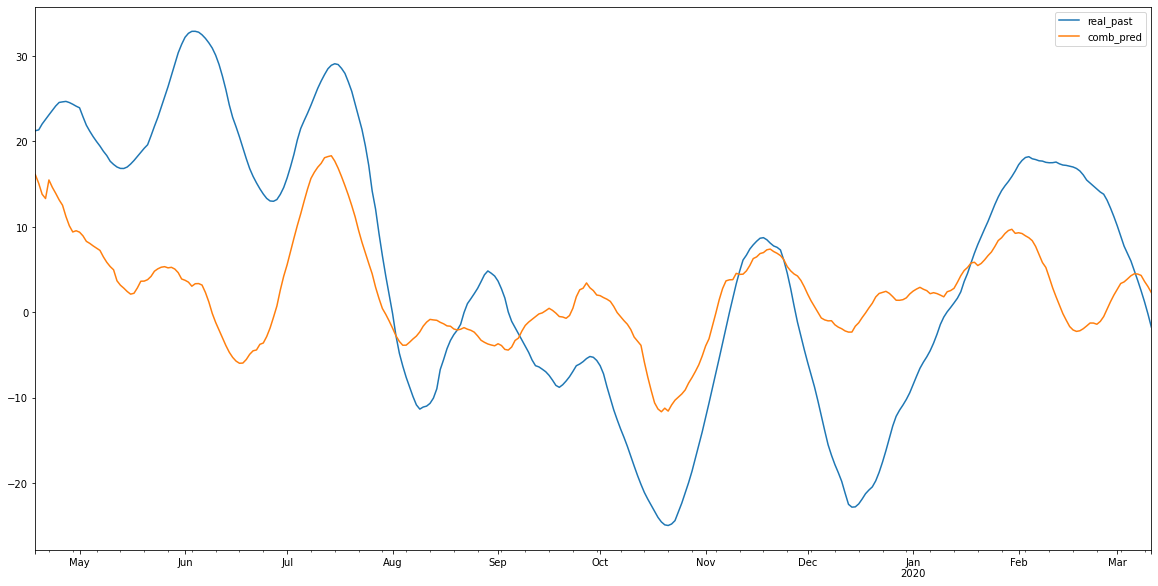

In [175]:
growth_dict[["real_past","comb_pred"]].rolling(window=20, min_periods=1).mean().plot(figsize=(20,10))